---
**Análisis exploratorio de datos: *Renal Cancer***

---

**Autor:** Acher Bizen Egido Mairal  
**Proyecto:** TFM - *Detección de enfermedades a través de modelos de clasificación multiclase aplicados a datasets de microARNs en biopsias líquidas*  
**Universidad Internacional de Valencia (VIU)**  
**Fecha de última modificación:** 29-10-2025  
**Fuente de datos:** [GSE140835 - MiR-765 functions as a tumor suppressor and regulates proliferation of renal cancer cells (NCBI GEO)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140835)

---
**Uso de Inteligencia Artificial en el desarrollo del código**

---
Este cuaderno ha sido elaborado combinando **desarrollo propio** con **asistencia de herramientas de Inteligencia Artificial**, empleadas de manera responsable y transparente.  
Durante la construcción del código se utilizaron principalmente **ChatGPT (OpenAI)** y **GitHub Copilot**, y en algunos casos **Claude (Anthropic)**, con el objetivo de:
- Generar estructuras base de código (funciones, pipelines, validaciones cruzadas, visualizaciones, etc.).  
- Explorar diferentes alternativas de implementación y optimización.  
- Solicitar aclaraciones teóricas y referencias para pasos metodológicos complejos o poco conocidos.

El flujo de trabajo relacionado con la IA consistió en:
1. Formular una misma consulta a dos IAs para contrastar enfoques.  
2. Seleccionar, validar y adaptar manualmente la mejor propuesta.  
3. Verificar el funcionamiento y exactitud del código a través de pruebas y búsqueda de documentación adicional.  

De este modo, la **IA se ha utilizado como herramienta de apoyo técnico y de aprendizaje**, no como sustituto del razonamiento ni del diseño metodológico.  
Todas las decisiones finales sobre preprocesamiento, modelado y análisis fueron tomadas por el autor tras validar los resultados empíricamente.


## **Librería de imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, re


from google.colab import drive
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Instalación de UMAP
!pip install umap-learn
from umap import UMAP

## **Biblioteca de funciones**


In [ ]:
# Guarda un resumen compacto del DataFrame para el reporte.
def snapshot_df(df, name, notes=""):
    info = {
        "name": name,
        "shape": df.shape,
        "index_name": df.index.name,
        "columns_n": len(df.columns),
        "na_cells": int(df.isna().sum().sum()),
        "rows_with_na": int(df.isna().any(axis=1).sum()),
        "cols_with_na": int(df.isna().any(axis=0).sum()),
        "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,
        "notes": notes
    }
    audit_log.append(info)
    display(pd.DataFrame([info]))

# Resumen de una serie categórica (clases, etc.).
def snapshot_value_counts(ser, name, notes=""):
    vc = ser.value_counts(dropna=False).rename("count").to_frame()
    display(pd.DataFrame({"name":[name], "notes":[notes]}))
    display(vc)

# Informa de miARNs duplicados en el índice.
def miRNA_dup_report(df, name):
    dups = df.index.duplicated(keep=False)
    n_dup = dups.sum()
    print(f"[{name}] miARNs duplicados en índice: {n_dup}")
    if n_dup:
        display(df.index[dups].to_series().value_counts().head(20))

def columns_intersection_report(cols_a, cols_b, name_a="A", name_b="B"):
    set_a, set_b = set(cols_a), set(cols_b)
    inter = set_a & set_b
    only_a = set_a - set_b
    only_b = set_b - set_a
    print(f"[{name_a}∩{name_b}] comunes: {len(inter)} | solo {name_a}: {len(only_a)} | solo {name_b}: {len(only_b)}")
    if len(only_a):
        print(f"Ejemplos solo {name_a}:", list(sorted(only_a))[:5])
    if len(only_b):
        print(f"Ejemplos solo {name_b}:", list(sorted(only_b))[:5])
    return inter, only_a, only_b

def library_size_plot(expr_df, title="Tamaño de librería por muestra"):
    libsize = expr_df.sum(axis=0)
    plt.figure()
    libsize.sort_values().plot(kind="bar")
    plt.title(title)
    plt.ylabel("Suma de cuentas (por muestra)")
    plt.xlabel("Muestras (GSM)")
    plt.tight_layout()
    plt.show()

def zero_fraction_plots(expr_df, title_prefix="Fracción de ceros"):
    frac_zero_genes = (expr_df == 0).sum(axis=1) / expr_df.shape[1]
    frac_zero_samples = (expr_df == 0).sum(axis=0) / expr_df.shape[0]

    plt.figure()
    frac_zero_genes.hist(bins=30)
    plt.title(f"{title_prefix} por miRNA")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    plt.figure()
    frac_zero_samples.hist(bins=30)
    plt.title(f"{title_prefix} por muestra")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


In [ ]:
# =================================================================================================================================================
# Lee un txt/csv (posible .gz) con separador sep, usa la PRIMERA columna como índice (independientemente del nombre), y devuelve un DataFrame.
# =================================================================================================================================================
def read_firstcol_as_index(path, sep="\t"):
    df = pd.read_csv(path, sep=sep, header=0)
    df = df.set_index(df.columns[0])
    return df

# ============================================
# Homogeneiza nombres de miARN en el índice:
#    - a minúsculas
#    - elimina prefijo 'hsa-' si aparece
#    - recorta espacios
#    Devuelve df con índice normalizado.
# ===========================================
def normalize_mirna_index(df):
    new_idx = (
        df.index.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r'^hsa-', '', regex=True)
    )
    df = df.copy()
    df.index = new_idx
    return df

# =====================================================
# Pasa de (miRNA x muestras) a (muestras x miRNA).
# =====================================================
def to_samples_x_features(expr_df):
    return expr_df.T.copy()


audit_log = []

## **Construcción del dataset**

In [ ]:
# =============================
# Montaje de Google Drive
# =============================
drive.mount('/content/drive')

base_path_mRCC = "/content/drive/MyDrive/Máster BigData y ciencia de datos VIU/TFM/Datos/Metastatic renal cell carcinoma (mRCC)"


Mounted at /content/drive


#### **Preparación del dataset de cáncer renal**

0 Log2 values for miRNAs with RPM>8
1 Patient ID	5012	5021	5026	5027	5029	5033	5035	5038	5040	5041	5042	5050	5053	5056	5058	5059	5068	5069	5075	5076	5078	5079	5080	5087	5092	5094	5095	5101	5104	5111	5112	5114	5116	5121	5122	5123	5128	5129	5130	5133	5141	5143	5145
2 hsa-miR-128-3p	18.04	17.53	16.94	17.56	17.44	17.31	18	18.13	17.64	17.72	17.3	17.69	17.02	17.98	17.44	17.98	17.93	17.41	17.05	17.79	17.26	17.09	17.91	17.49	17.83	17.86	17.74	17.39	17.71	17.22	17.75	17.58	17.25	17.7	17.58	17.16	17.18	17.89	17.58	17.89	17.04	18.21	17.53
3 hsa-miR-99a-5p	16.92	17.35	17.32	17.31	17.27	16.85	16.58	16.72	17.36	17.43	17.65	17.35	17.49	17.29	17.49	17.18	17.33	17.38	17.56	17.29	17.23	17.44	17.31	17.41	17.18	17.33	17.13	17.34	17.38	17.52	17.34	17.29	17.49	17.36	17.31	17.47	17.5	17.14	17.44	17.32	17.6	17.22	17.53
4 hsa-miR-9-5p	15.84	15.75	16.12	16.42	15.88	15.66	16	15.58	16.01	15.8	15.4	15.75	15.84	15.75	15.97	15.95	15.42	16.5	15.77	16.13	15.46	16.18	15.61	15.74	16.21	15.83	15.62	16.06	15.9	15.84	15.82

,5012,5021,5026,5027,5029,5033,5035,5038,5040,5041,...,5121,5122,5123,5128,5129,5130,5133,5141,5143,5145
Patient ID,,,,,,,,,,,,,,,,,,,,,
hsa-miR-128-3p,18.04,17.53,16.94,17.56,17.44,17.31,18.00,18.13,17.64,17.72,...,17.70,17.58,17.16,17.18,17.89,17.58,17.89,17.04,18.21,17.53
hsa-miR-99a-5p,16.92,17.35,17.32,17.31,17.27,16.85,16.58,16.72,17.36,17.43,...,17.36,17.31,17.47,17.50,17.14,17.44,17.32,17.60,17.22,17.53
hsa-miR-9-5p,15.84,15.75,16.12,16.42,15.88,15.66,16.00,15.58,16.01,15.80,...,15.90,15.86,16.08,15.89,15.93,15.90,15.82,15.38,15.44,15.82


Descartando columnas no numéricas: ['5033']
Renal (miRNA x muestras): (322, 42)


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,expr_renal (crudo),"(322, 42)",Patient ID,42,0,0,0,0,miRNA x muestras · GEO txt.gz (posible log2)


,5012,5021,5026,5027,5029,5035,5038,5040,5041,5042,...,5121,5122,5123,5128,5129,5130,5133,5141,5143,5145
Patient ID,,,,,,,,,,,,,,,,,,,,,
hsa-miR-505-3p,4.81,4.56,4.20,4.39,4.31,4.35,4.50,4.25,4.45,4.40,...,4.13,4.55,4.26,3.67,4.43,3.74,4.11,4.43,4.21,3.74
hsa-miR-411-3p,7.10,6.38,6.32,5.83,6.13,6.80,6.87,6.61,6.77,6.34,...,6.46,6.25,6.30,6.13,6.76,6.26,6.39,5.84,6.84,6.48
hsa-miR-181a-3p,6.87,6.79,7.20,7.25,6.74,6.43,6.36,7.04,6.92,6.98,...,6.85,6.75,6.94,6.84,6.72,6.89,6.82,7.17,6.86,7.15


,5027,5026,5092,5141,5075,5112,5078,5128,5116,5087
Patient ID,,,,,,,,,,
hsa-miR-128-3p,17.56,16.94,17.83,17.04,17.05,17.75,17.26,17.18,17.25,17.49
hsa-miR-99a-5p,17.31,17.32,17.18,17.60,17.56,17.34,17.23,17.50,17.49,17.41
hsa-miR-9-5p,16.42,16.12,16.21,15.38,15.77,15.82,15.46,15.89,16.09,15.74
hsa-miR-129-5p,15.27,15.16,14.90,15.87,15.46,15.23,15.82,15.40,15.51,15.48
hsa-let-7b-5p,14.20,15.00,14.72,14.56,15.26,14.77,16.41,15.00,14.75,14.67


Rango de valores: [0.940, 18.210]
Fracción de ceros (global): 0.000000
Escala aparente: log2 (intensidades)


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,métricas por muestra,"(42, 8)",None,8,0,0,0,42,cada fila = métrica; cada columna = muestra


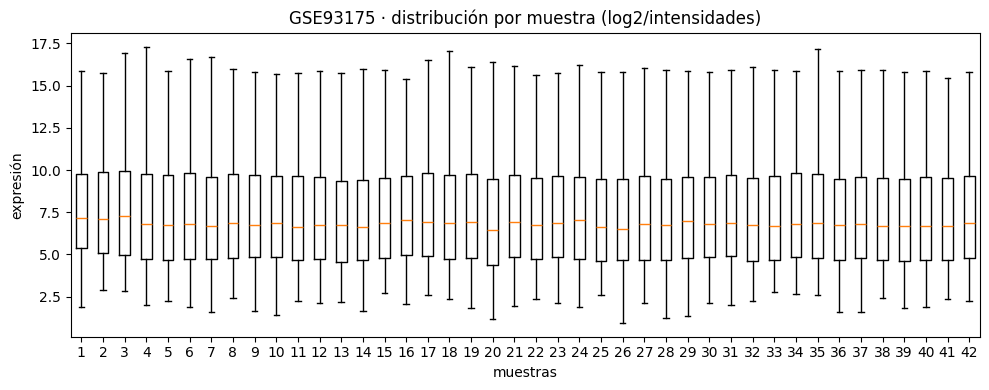

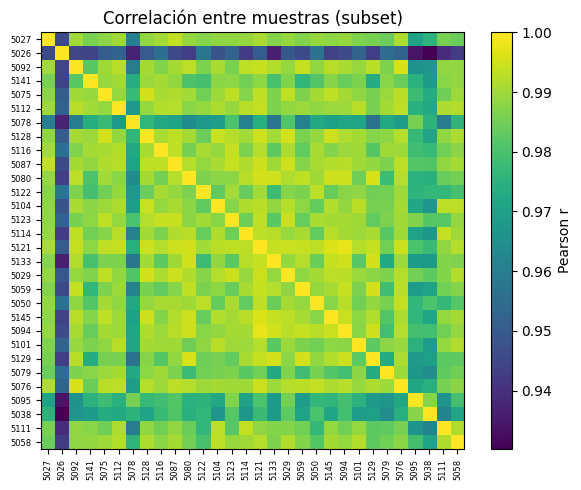

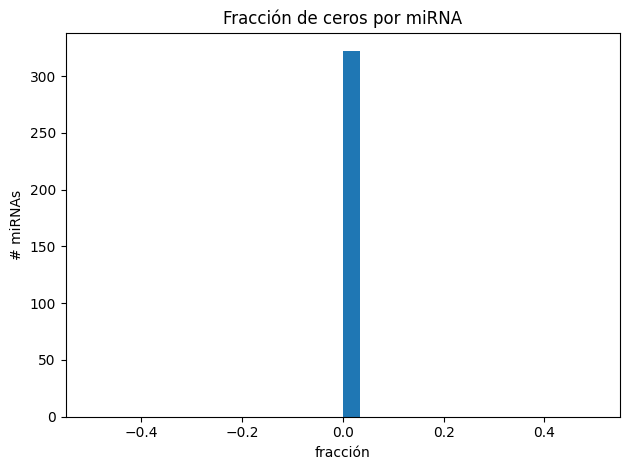

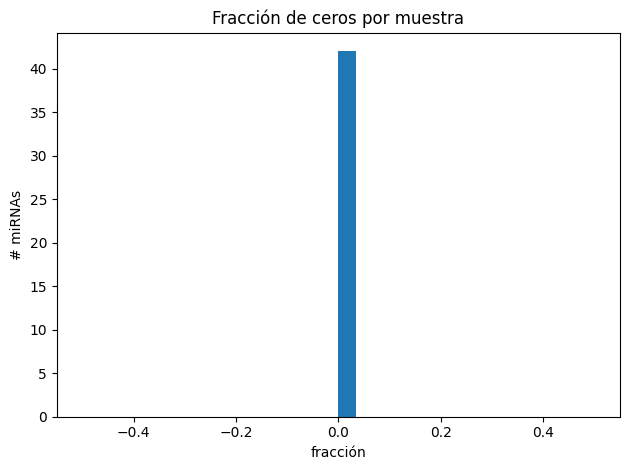

X_renal: (42, 322) | y_renal: 42


Patient ID,hsa-miR-128-3p,hsa-miR-99a-5p,hsa-miR-9-5p,hsa-miR-129-5p,hsa-let-7b-5p
5012,18.04,16.92,15.84,14.88,14.60
5021,17.53,17.35,15.75,15.11,14.68
5026,16.94,17.32,16.12,15.16,15.00


In [ ]:
# ================================
# Renal (mRCC): expresión (xlsx)
# ================================

expr_renal_path = f"{base_path_mRCC}/GSE93175_miRNA_322selected_RC8_log2.txt.gz"

# Exploración de las primeras líneas para ver la estructura
with gzip.open(expr_renal_path, "rt") as f:
    for i in range(10):
        print(i, f.readline().strip())


expr_renal = pd.read_csv(
    expr_renal_path,
    sep="\t",
    header=1,
    index_col=0
)
print("Renal (miRNA x muestras):", expr_renal.shape)
display(expr_renal.head(3))

# Limpieza y estudo del dataset
# Elimino las columnas no numéricas
non_numeric_cols = [c for c in expr_renal.columns if not pd.api.types.is_numeric_dtype(expr_renal[c])]
if non_numeric_cols:
    print("Descartando columnas no numéricas:", non_numeric_cols)
    expr_renal = expr_renal.drop(columns=non_numeric_cols)

# Compruebo que todo es numérico y que no hay NaN
expr_renal = expr_renal.apply(pd.to_numeric, errors="coerce").fillna(0)


# -------------------------------------------- METADATOS -----------------------------------------------
# Snapshots
print("Renal (miRNA x muestras):", expr_renal.shape)
snapshot_df(expr_renal, "expr_renal (crudo)", notes="miRNA x muestras · GEO txt.gz (posible log2)")
display(expr_renal.sample(n=min(3, expr_renal.shape[0]), axis=0, random_state=1))
display(expr_renal.sample(n=min(10, expr_renal.shape[1]), axis=1, random_state=1).head(5))

# Perfil numérico y heurística log2
vmin, vmax = float(np.nanmin(expr_renal.values)), float(np.nanmax(expr_renal.values))
zero_frac = float((expr_renal.values == 0).mean())  # con log + pseudocount suele ser ~0
is_logish = (vmax <= 25) and (vmin >= -5)  # heurística simple

print(f"Rango de valores: [{vmin:.3f}, {vmax:.3f}]")
print(f"Fracción de ceros (global): {zero_frac:.6f}")
print("Escala aparente:", "log2 (intensidades)" if is_logish else "conteos/RPM (no log)")

# Métricas por muestra (utilizado para detectar outliers en log2)
sample_stats = pd.DataFrame({
    "min": expr_renal.min(axis=0),
    "q1": expr_renal.quantile(0.25, axis=0),
    "median": expr_renal.median(axis=0),
    "q3": expr_renal.quantile(0.75, axis=0),
    "max": expr_renal.max(axis=0),
    "mean": expr_renal.mean(axis=0),
    "std": expr_renal.std(axis=0),
    "zeros": (expr_renal == 0).sum(axis=0)
})
snapshot_df(sample_stats, "métricas por muestra", notes="cada fila = métrica; cada columna = muestra")

# Gráfica distribución/correlación
plt.figure(figsize=(10, 4))
plt.boxplot(expr_renal.values, showfliers=False)
plt.title("GSE93175 · distribución por muestra (log2/intensidades)")
plt.xlabel("muestras"); plt.ylabel("expresión"); plt.tight_layout(); plt.show()

# Heatmap de correlación entre muestras
k = min(30, expr_renal.shape[1])
rng = np.random.RandomState(1)
subset_cols = list(rng.choice(expr_renal.columns, size=k, replace=False)) if k > 0 else expr_renal.columns.tolist()
corr = expr_renal[subset_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, aspect='auto')
plt.colorbar(label='Pearson r')
plt.title("Correlación entre muestras (subset)")
plt.xticks(range(len(subset_cols)), subset_cols, rotation=90, fontsize=6)
plt.yticks(range(len(subset_cols)), subset_cols, fontsize=6)
plt.tight_layout(); plt.show()

# Fracción de ceros por miRNA y por muestra
zero_frac_rows = (expr_renal == 0).mean(axis=1)
zero_frac_cols = (expr_renal == 0).mean(axis=0)

plt.figure()
plt.hist(zero_frac_rows, bins=30)
plt.title("Fracción de ceros por miRNA"); plt.xlabel("fracción"); plt.ylabel("# miRNAs")
plt.tight_layout(); plt.show()

plt.figure()
plt.hist(zero_frac_cols, bins=30)
plt.title("Fracción de ceros por muestra"); plt.xlabel("fracción"); plt.ylabel("# miRNAs")
plt.tight_layout(); plt.show()

# Matriz (muestras x miRNA) y etiquetas
X_renal = expr_renal.T.copy()
y_renal = ["Renal_mRCC"] * X_renal.shape[0]
print("X_renal:", X_renal.shape, "| y_renal:", len(y_renal))
display(X_renal.iloc[:3, :5])


---

**GSE93175_miRNA_322selected_RC8_log2.txt.gz**

---

Este archivo de GEO contiene la **matriz de expresión de miRNAs** seleccionados en exosomas de pacientes mRCC. En la **primera línea** se encuentra una descripción, que indica que **los valores ya están transformados en log2** y que **se han preseleccionado miRNAs con RPM > 8**, quedándose únicamente con **322**. En la siguiente línea se encuentra la cabecera con 'Patient ID' y con los IDs de muestra.

La estructura que se ha cargado contiene:
- **Filas (322)**: Cada fila es un miRNA.
- **Columnas (42)**: Cada columna es una muestra/paciente (tras limpiar 1 columna problemática).
- **Valores**: Intensidades log2 (**no son cuentas crudas**).

---

**Resultados de la exploración**

---

1. **Dimensiones y preprocesado**
    - **322 miRNAs seleccionados por RPM > 8**, hay que tener en cuenta más adelante que ya hay un filtro de abundancia aplicado.
    - **42 muestras útiles (tras retirar 5033 por no numérica)**.

2. **Escala y distribución**
    - **Rango 0.94-18.21 y cero ceros**: log2 de intensidades *positivas*. Lo que conlleva que no hace falta hacer un filtrado previo y que no hay que normalizar (a diferencia del pancreático).
    - **Boxplots homogéneos**: Es decir, no parece que haya outliers claros ni desplazamientos entre muestras.

3. **Correlación entre muestras**
    - Aparece una **correlación muy alta (≈0.95-1.00)**. Lo que implica que gran parte de la variación está compartida (miRNAs altamente expresados). Si luego quiero hacer algún análisis discriminatorio, tendré que **centrar/escalar por miRNA** (por ejemplo utilizando z-score), **filtrar por varianza** (quedandome los más variables) o usar **modelos penalizadores como LASSO o ElasticNet**.

4. **Sparsidad**
    - No se aprecia sparsidad, por lo que no voy a necesitar filtros por *presencia en X% de muestras* como en el pancreático. Lo que igual si que puedo ahcer es utilizar un filtrado por varianza o MAD para **eliminar miRNAs casi constantes**.




---
**Exploración inicial de los datos (GSE93175)**

---

La matriz de expresión contiene **322 miRNAs y 42 muestras de pacientes con mRCC** (se excluyó una columna no numérica asociada al ID 5033). Los valores corresponden a intensidades en **escala log2 ya pre-filtradas por abundancia (RPM > 8)**, tal y como indica el propio fichero de GEO.

Las distribuciones por muestra (boxplots) son muy homogéneas, con rangos aproximados 0.94–18.21 y **sin outliers evidentes ni desplazamientos entre grupos**; de hecho, la **correlación entre muestras es alta** (r ≈ 0,95–1,00) y no sugiere efectos de lote marcados. La fracción de ceros tanto por miRNA como por muestra es prácticamente nula, lo cual es esperable tras el filtrado por RPM y la transformación logarítmica; por ello, a diferencia del dataset pancreático con cuentas crudas, el análisis de *tamaño de librería* no resulta informativo aquí.

In [ ]:
# =======================================================
# Renal (mRCC): normalización de nombres y transponer
# =======================================================
expr_renal = normalize_mirna_index(expr_renal)

# (muestras x miRNA)
X_renal = expr_renal.T.copy()

# Etiquetas (solo hay una clase en este caso --> Renal_mRCC)
y_renal = ["Renal_mRCC"] * X_renal.shape[0]

print("X_renal:", X_renal.shape, "| y_renal:", len(y_renal))
display(X_renal.iloc[:3, :5])


X_renal: (42, 322) | y_renal: 42


Patient ID,mir-128-3p,mir-99a-5p,mir-9-5p,mir-129-5p,let-7b-5p
5012,18.04,16.92,15.84,14.88,14.60
5021,17.53,17.35,15.75,15.11,14.68
5026,16.94,17.32,16.12,15.16,15.00


---
**Transformaciones realizadas (mRCC · GSE93175)**

---
1. **Normalización de nombres de miRNA.** Se ha aplicado *normalize_mirna_index* para homogeneizar las claves (p. ej., *hsa-miR-128-3p* pasa a *mir-128-3p*).

2. **Transposición de la matriz.** La matriz original **(miRNA × muestras)** se ha transpuesto a **(muestras × miRNA)** para trabajar en el formato habitual de scikit-learn.


In [ ]:
# ===================================
# Renal (mRCC): metadatos mínimos
# ===================================
meta_renal = pd.DataFrame({
    "sample_id": X_renal.index,
    "label": y_renal,
    "dataset": "GSE93175",
    "matrix_type": "plasma_exosome"
})
print("Metadatos renal:", meta_renal.shape)
display(meta_renal.head(3))

# ------------------------------------ METADATOS ------------------------------------------------
# Estado de expr_renal (miRNA x muestras, en log2)
snapshot_df(expr_renal, "expr_renal (crudo-log2)", notes="miRNA x muestras; 322x43")

# Estado de X_renal (muestras x miRNA)
snapshot_df(X_renal, "X_renal (transpuesto)", notes="muestras x miRNA; 43x322")

# Estado de metadatos mínimos
snapshot_df(meta_renal, "meta_renal (min)", notes="sample_id/label/dataset/matrix_type")
snapshot_value_counts(meta_renal["label"], "Distribución de clases (renal)")


Metadatos renal: (42, 4)


,sample_id,label,dataset,matrix_type
0,5012,Renal_mRCC,GSE93175,plasma_exosome
1,5021,Renal_mRCC,GSE93175,plasma_exosome
2,5026,Renal_mRCC,GSE93175,plasma_exosome


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,expr_renal (crudo-log2),"(322, 42)",Patient ID,42,0,0,0,0,miRNA x muestras; 322x43


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,X_renal (transpuesto),"(42, 322)",None,322,0,0,0,0,muestras x miRNA; 43x322


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,meta_renal (min),"(42, 4)",None,4,0,0,0,None,sample_id/label/dataset/matrix_type


,name,notes
0,Distribución de clases (renal),


,count
label,
Renal_mRCC,42



---
**meta_renal**

---

Se ha creado *meta_renal* con cuatro campos:
  - **sample_id**: ID de muestra, tomado del índice de X_renal
  - **label**: En este caso sólo hay una clase, que es "Renal_mRCC".
  - **dataset**: "GSE93175"
  - **matrix_type**: "plasma_exosome".

**Los 42 registros quedan perfectamente alineados con X_renal**.

---
**Resultados finales**

---
- **Metadatos**: **expr_renal**, contiene 322 x 42, sin NA ni ceros (consistente con log2 y filtro RPM > 8).Y por otro lado, ***X_renal*** contiene 42 x 322, sin NA.

- **Distribución de clases**: En este dataset hay una única clase: Renal_mRCC, con 42 muestras.

**Posible texto para la memoria**

---

**Exploración inicial de los datos (GSE93175)**

La matriz de expresión contiene **322 miRNAs y 42 muestras de pacientes con mRCC** (tras excluir una columna no numérica). **Los valores son intensidades en escala log2 y provienen de miRNAs preseleccionados por abundancia (RPM > 8)**.

Al explorar la distribución por muestra (boxplots) se observa una alta homogeneidad entre perfiles, con rangos aproximados 0.94-18.21 y sin outliers evidentes ni desplazamientos sistemáticos. La correlación entre muestras es también elevada (r ≈ 0.95-1.00), lo que sugiere que el conjunto ya ha pasado por un proceso de normalización/curación. En este contexto, el análisis de “tamaño de librería” no resulta informativo al no trabajar con cuentas crudas.

Asimismo, la **fracción de ceros es prácticamente nula** tanto por miRNA como por muestra, en consonancia con el filtrado por RPM y la transformación logarítmica. Por ello, a diferencia de datasets con conteos crudos, no es necesario un filtrado por baja abundancia.

---
**Posible texto para la memoria**

---
**Construcción del dataset de trabajo (GSE93175 · mRCC)**

A partir del fichero de expresión de GEO *GSE93175_miRNA_322selected_RC8_log2.txt.gz* (**miARNs preseleccionados por RPM > 8 y valores en escala log**2), se armonizaron los identificadores con *normalize_mirna_index* y se extrajeron los IDs de paciente de la cabecera (“Patient ID”), lo que permitió **emparejar sin ambigüedades cada muestra con su columna en la matriz**.

Tras descartar una columna no numérica asociada a un ID (5033), se ha obtenido una matriz *X_renal* en formato scikit-learn de **42 muestras x 322 miRNAs** (transposición de la matriz original), junto con un **vector de etiquetas** *y_renal* en el que todas las muestras se etiquetan como *Renal_mRCC* (esta serie no incluye controles). Además, se ha construido un **conjunto mínimo de metadatos** (*meta_renal*) con los campos *sample_id*, *label*, *dataset* (=GSE93175) y *matrix_type* (=“plasma_exosome”), útil para el seguimiento y la integración con análisis posteriores.

Dado que solo existe una clase, este dataset es idóneo para exploración no supervisada (PCA/UMAP), no obstante en caso de requerir clasificación caso/control (como es el caso de este TFM), es necesario integrarlo con un conjunto compatible que aporte muestras de referencia.

## **Preprocesado del dataset de Cáncer renal**

---
**Preprocesado**

---
A diferencia de dataset de cáncer de páncreas, en este caso **ya contamos con un dataset previamente filtardo y en log2**, asi que estas transformaciones no las voy a rehacer para este dataset.
Lo que si que se ha hecho es **quitar los features constantes (varianza 0)**, ya que estas no aportan información y voy a **calcular el z-score por miRNA** para facilitar una futura PCA/UMAPy sobre todo, para compatibilizar la escala con el dataset pancreatico.


In [ ]:
# ==========================================
# Preprocesado mínimo · mRCC (GSE93175)
# - Se mantiene la escala log2 original
# - Se eliminan los miRNAs de varianza cero
# - Se crea una versión z-score para exploración y fusión entre datasets
# ==========================================

# Comprobación ligera de valores NA --> (No hay ya lo he comprobado antes, pero por si acaso)
if X_renal.isna().any().any():
    print("Aviso: se han encontrado NA en X_renal; se reemplazan por 0 para continuar.")
    X_renal = X_renal.fillna(0)

# Elimino los miRNAs constantes (varianza = 0)
var_renal = X_renal.var(axis=0, ddof=0)
mask_nonconst = var_renal > 0
dropped_const = int((~mask_nonconst).sum())
if dropped_const > 0:
    print(f"Eliminando {dropped_const} miRNAs constantes (sin variación entre muestras).")

X_renal_log = X_renal.loc[:, mask_nonconst].copy()  # seguimos en log2
print("X_renal_log (tras quitar constantes):", X_renal_log.shape)

# z-score por miRNA (Usado luego en PCA/UMAP y para fusionar con los otros datasets)
def zscore_by_feature(df_mxf: pd.DataFrame) -> pd.DataFrame:
    mu = df_mxf.mean(axis=0)
    sd = df_mxf.std(axis=0, ddof=0).replace(0, np.nan)
    z = (df_mxf - mu) / sd
    return z.fillna(0.0)

X_renal_z = zscore_by_feature(X_renal_log)


print("X_renal_z (muestras x miRNA, z-score):", X_renal_z.shape)
snapshot_df(X_renal_log.T, "expr_renal (log2 · no-constantes)", notes="miRNA x muestras (log2)")
snapshot_df(X_renal_z, "X_renal_z", notes="muestras x miRNA (z-score por miRNA)")


X_renal_log (tras quitar constantes): (42, 322)
X_renal_z (muestras x miRNA, z-score): (42, 322)


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,expr_renal (log2 · no-constantes),"(322, 42)",Patient ID,42,0,0,0,0,miRNA x muestras (log2)


/tmp/ipython-input-3444336874.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,X_renal_z,"(42, 322)",None,322,0,0,0,1,muestras x miRNA (z-score por miRNA)


---
**Resultados del preprocesado**

---
Tras quitar las constantes **se mantienen los 322 miRNAs**, es decir, **no había ningún feature de varianza cero**. Se mantiene el formato *muestras x miRNA* y en log2.



---
**Posible texto para la memoria**

---
**Preprocesado del dataset mRCC (GSE93175)**

Dado que el fichero de expresión de mRCC **ya contiene miRNAs preseleccionados por abundancia (RPM>8)** y los **valores están en escala log2**, no se han aplicado ni filtrado de baja abundancia adicional ni normalizaciones por tamaño de librería. Como paso mínimo de calidad, se **han eliminado los miRNAs con varianza nula** (sin información discriminativa).

Con el objetivo de facilitar tanto la exploración (PCA/UMAP) como la integración con otros conjuntos (p. ej., páncreas), se ha generado una **versión estandarizada por miRNA (z-score por columna)**. Esta estrategia preserva la escala logarítmica original del dataset renal y, al mismo tiempo, armoniza los datos cuando se fusionan con matrices transformadas a log2(CPM+1), reduciendo efectos de escala entre estudios.

## **Exploración del dataset**

En un primer lugar voy a utilizar técnicas de **reducción de la dimensionaliad**, para poder observar agrupaciones en los datasets con muchos datos.

1. **PCA (Principal Component Analysis)**: Busca combinaciones lineales de las variables originales (los 322 miARNs) que maximicen la varizanza explicada.

2. **UMAP (Uniform Manifold Approximation and Projection)**: Modela los datos como un grafo de proximidad (vecinos cercanos en el espacio de alta dimensión). Intenta preservar esas relaciones de vecindad al proyectar a 2D.


### **PCA exploratoria**

**Características de la PCA:**
- Es un **método lineal**, que **preserva la estructura global de los datos** (direcciones de mayor variabilidad).
- Cada eje (PC1, PC2) tiene una **cantidad clara de varianza explicada**.
- Permite relacionar directamente los componentes con combinaciones de miARNs.

**Limitaciones:**
    
- Si las separaciones entre clases están dadas por relaciones no lineales, puede no captarlas bien.
- Los gráficos PCA a veces muestran solapamiento fuerte aunque en el espacio original haya estructuras más complejas.

Varianza explicada PC1: 23.73%
Varianza explicada PC2: 17.99%
Acumulada PC1–PC10: 79.68%


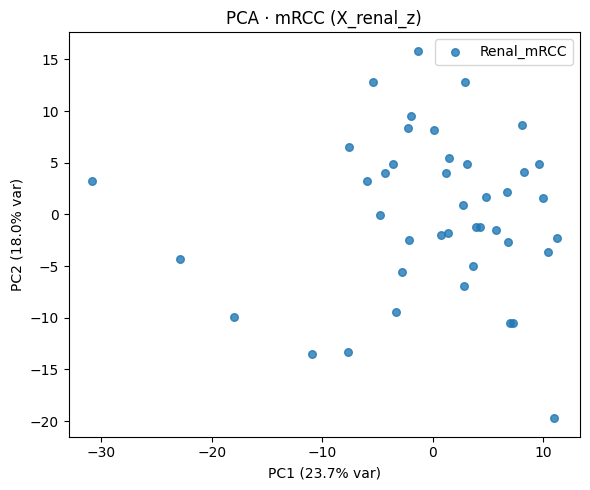

In [ ]:
# =============================
# PCA · mRCC (sobre X_renal_z)
# =============================

# Nota: X_renal_z ya es z-score por columna, así que NO tengo que escalar
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_renal_z.values)

pca_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"], index=X_renal_z.index)
# Etiquetas (serán todas iguales, pero lo mantengo por consistencia)
pca_df["label"] = meta_renal.set_index("sample_id").reindex(X_renal_z.index)["label"].fillna("Renal_mRCC").values

print(f"Varianza explicada PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Varianza explicada PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Acumulada PC1–PC10: {pca.explained_variance_ratio_[:10].sum()*100:.2f}%")

plt.figure(figsize=(6,5))
for lab, sub in pca_df.groupby("label"):
    plt.scatter(sub["PC1"], sub["PC2"], alpha=0.8, label=lab, s=30)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA · mRCC (X_renal_z)")
plt.legend()
plt.tight_layout()
plt.show()

### **UMAP por enfermedad**


Proyecta las muestras a 2D para ver si las clases biológicas (BreastCancer, Renal_mRCC, PancreasCancer, IPMN, Pancreatitis) forman clústeres separados. Detecta estructura no lineal que el PCA podría no mostrar.

**Características de UMAP:**
- Modelo no lineal
- Pone más énfasis en la estructura local (agrupa puntos que son vecinos).
- Produce representaciones 2D en las que los puntos que están cercanos en la gráfica suelen ser *parecidos* en los datos originales.
- Los ejes (UMAP1, UMAP2) no tienen varianza explicada interpretable como en PCA.

**Ventajas frente a PCA:**
- Detecta clusters no lineales y separaciones complejas.
- Suele dar visualizaciones más claras de grupos/clases.

**Limitaciones:**
- No es determinista al 100% (cambia con random_state).
- No permite una interpretación directa de *qué miARN pesa más en UMAP1*.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


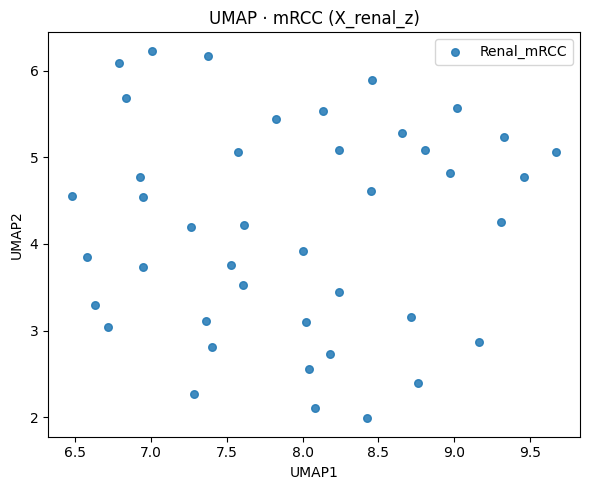

In [ ]:
# =============================
# UMAP · mRCC (sobre X_renal_z)
# =============================

umap = UMAP(
    n_components=2,
    n_neighbors=10,      # para n=42, 8–15 (valores estandar, que suelen ir bien)
    min_dist=0.1,
    metric="euclidean",  # También he probado con "cosine" (son muy similares)
    random_state=42
)
X_umap = umap.fit_transform(X_renal_z.values)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=X_renal_z.index)
umap_df["label"] = pca_df["label"].values

plt.figure(figsize=(6,5))
for lab, sub in umap_df.groupby("label"):
    plt.scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.85, label=lab, s=30)
plt.title("UMAP · mRCC (X_renal_z)")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.legend()
plt.tight_layout()
plt.show()

---
**Posible texto  para la memoria**

---
**Reducción de dimensionalidad (mRCC, 42 × 322)**

Se han aplicado **PCA** y **UMAP** sobre la **matriz estandarizada por miRNA** (X_renal_z, z-score por columna). En **PCA** se han calculado las dos primeras componentes principales y su **varianza explicada**, con el objetivo de evaluar cuánta estructura lineal capturan y detectar posibles tendencias globales u outliers.

La proyección **UMAP** (parámetros: n_neighbors=10, min_dist=0.1, métrica euclídea) permite explorar relaciones de vecindad en 2D, más adecuadas para patrones no lineales. Dado que este conjunto es monoclase (todas las muestras mRCC), las proyecciones se han interpretado en clave exploratoria, buscando subestructuras latentes o señales técnicas, y dejando preparada la configuración para su integración con el dataset de páncreas (donde se aplicará el mismo z-score por miRNA antes de combinar).

# **Selección de características**



---
**Selección de características.**

---
Como este dataset es **monoclase** (todas las muestras mRCC) y encima con miRNAs ya filtrados por RPM>8 y en log2, se han tomado diferentes decisiones y se han aplicado otras técnicas de selección de características a diferencia del dataset de cáncer pancreatico

- **NO replico métodos supervisados que requieren clases** (p.ej., ANOVA, Kruskal–Wallis, Mutual Information, Cohen’s d, log2FC, Logistic Regression/ Random Forest como selección embebida). Los aplicaré después, cuando fusione con páncreas y mama (caso vs control).

- **SÍ que hago una selección no supervisada, adecuada a monoclase**:
  1. **Varianza (log2) y MAD robusto (log2)** → priorizan miRNAs con mayor variabilidad real.
  2. **Peso estructural en PCA** (cargas² ponderadas por varianza explicada hasta ~80%) sobre X_renal_z → identifica miRNAs que sostienen la estructura global.
  3. **Consenso de rankings** (promedio de rangos normalizados) → lista ordenada estable.
  4. **Poda por correlación** (|ρ|≥0.85) sobre X_renal_z → panel no redundante de tamaño K (p.ej., 100).

Esto deja un panel compacto y armónico con el pipeline de fusión: cuando juntes páncreas + mRCC + mama (todos en z-score por miRNA y con intersección de genes), ya se podrá ejecutar ANOVA/Kruskal/MI, tamaños de efecto y modelos embebidos sobre el conjunto combinado.

In [ ]:
# ==========================================
# Rankings no supervisados + consenso · mRCC
# ==========================================
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Entradas esperadas:
# - X_renal_log : (muestras x miRNA) en log2, sin constantes
# - X_renal_z   : (muestras x miRNA) z-score por miRNA

# Varianza y MAD (log2)
var_scores = X_renal_log.var(axis=0, ddof=0)
mad_scores = (X_renal_log - X_renal_log.median(axis=0)).abs().median(axis=0)

# PCA (robusto) sobre z-score
target_coverage = 0.80
max_pcs = min(25, X_renal_z.shape[0] - 1, X_renal_z.shape[1])
pca = PCA(n_components=max_pcs, random_state=42)
pca.fit(X_renal_z.values)

cum = np.cumsum(pca.explained_variance_ratio_)
k_raw = int(np.searchsorted(cum, target_coverage) + 1)
k = min(k_raw, len(cum))
coverage = float(cum[k-1]) if k > 0 else 0.0

W = pca.components_[:k, :]
weights = pca.explained_variance_ratio_[:k]
pca_score = (weights[:, None] * (W ** 2)).sum(axis=0)
pca_scores = pd.Series(pca_score, index=X_renal_z.columns)

print(f"PCA: usando {k} PCs (cobertura {coverage*100:.1f}%).")

# Consenso (rango normalizado; 0 = mejor)
def rank_to_unit(score_s: pd.Series, descending: bool = True) -> pd.Series:
    s = score_s.sort_values(ascending=not descending)
    ranks = pd.Series(range(len(s)), index=s.index).astype(float)
    return (ranks / max(len(s)-1, 1)).reindex(score_s.index)

r_var = rank_to_unit(var_scores, descending=True)
r_mad = rank_to_unit(mad_scores, descending=True)
r_pca = rank_to_unit(pca_scores, descending=True)

consensus_rank = (r_var + r_mad + r_pca) / 3.0      # 0 = mejor
consensus_rank.name = "consensus_rank"

# Vistas rápidas (Top-20 por criterio)
display(var_scores.sort_values(ascending=False).head(20).to_frame("variance"))
display(mad_scores.sort_values(ascending=False).head(20).to_frame("MAD"))
display(pca_scores.sort_values(ascending=False).head(20).to_frame("PCA_weighted_loading2"))
display(consensus_rank.sort_values(ascending=True).head(20).to_frame("consensus_rank"))


PCA: usando 11 PCs (cobertura 81.8%).


,variance
Patient ID,
mir-584-5p,2.629408
mir-126-5p,1.754649
mir-323b-3p,1.654782
mir-122-5p,1.393987
mir-3591-3p,1.384691
mir-3615,1.220174
mir-629-5p,1.143955
mir-28-3p,1.140519
mir-223-5p,1.055638


,MAD
Patient ID,
mir-486-5p,0.810
mir-486-3p,0.795
mir-4492,0.700
mir-3591-3p,0.700
mir-34b-3p,0.695
mir-122-5p,0.690
mir-3615,0.645
mir-16-2-3p,0.600
mir-6087,0.575


,PCA_weighted_loading2
Patient ID,
mir-146a-5p,0.003039
mir-146b-5p,0.003023
mir-128-3p,0.003015
mir-328-3p,0.003011
mir-760,0.003009
mir-22-3p,0.002998
let-7d-3p,0.002987
mir-125a-3p,0.002984
mir-204-3p,0.002978


,consensus_rank
Patient ID,
mir-584-5p,0.039460
mir-323b-3p,0.047767
let-7d-3p,0.053998
mir-328-3p,0.064382
mir-1273g-3p,0.069574
mir-3615,0.073728
mir-126-5p,0.077882
mir-125a-5p,0.091381
mir-223-5p,0.091381


#### **Carga, saneado y chequeos**

La idea es segurarme que las entradas están limpias, alineadas y sin constantes ni NaNs que rompan PCA/correlaciones.

In [ ]:
# Carga, saneado y chequeos
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
rng = np.random.default_rng(42)

def _assert_inputs(X_log: pd.DataFrame, X_z: pd.DataFrame):
    assert isinstance(X_log, pd.DataFrame) and isinstance(X_z, pd.DataFrame), "Entradas deben ser DataFrames."
    assert X_log.shape[1] == X_z.shape[1], "Columnas no coinciden en número."
    assert (X_log.columns == X_z.columns).all(), "Columnas no coinciden en orden/nombre."

    # Quito las columnas constantes (varianza 0 en log2)
    const_mask = X_log.var(axis=0, ddof=0) == 0
    if const_mask.any():
        drop_cols = X_log.columns[const_mask].tolist()
        X_log = X_log.drop(columns=drop_cols)
        X_z   = X_z.drop(columns=drop_cols)

    # Imputación mínima
    if X_log.isna().any().any():
        X_log = X_log.fillna(X_log.median())
    if X_z.isna().any().any():
        X_z = X_z.fillna(0.0)

    return X_log, X_z

Xlog_ok, Xz_ok = _assert_inputs(X_renal_log, X_renal_z)
print("OK · Xlog_ok:", Xlog_ok.shape, "Xz_ok:", Xz_ok.shape)


OK · Xlog_ok: (42, 322) Xz_ok: (42, 322)


#### **Rankings por varianza: Variabilidad y MAD**

Quiero priorizar los miARNs con mayor variación real dentro de la única clase que hay.

In [ ]:
# Varianza y MAD (log2)
var_scores = Xlog_ok.var(axis=0, ddof=0)
mad_scores = (Xlog_ok - Xlog_ok.median(axis=0)).abs().median(axis=0)

print("Top-5 por varianza:")
print(var_scores.sort_values(ascending=False).head(5))
print("\nTop-5 por MAD:")
print(mad_scores.sort_values(ascending=False).head(5))


Top-5 por varianza:
Patient ID
mir-584-5p     2.629408
mir-126-5p     1.754649
mir-323b-3p    1.654782
mir-122-5p     1.393987
mir-3591-3p    1.384691
dtype: float64

Top-5 por MAD:
Patient ID
mir-486-5p     0.810
mir-486-3p     0.795
mir-4492       0.700
mir-3591-3p    0.700
mir-34b-3p     0.695
dtype: float64


#### **Peso estructural global vía PCA (en z-score)**

Voy a identificar los miARNs que sostienen la estructura global de la clase (cargas²) ponderadas por varianza explicada.

In [ ]:
# PCA ponderado en Xz_ok
target_coverage = 0.80
max_pcs = min(25, Xz_ok.shape[0] - 1, Xz_ok.shape[1])

pca = PCA(n_components=max(max_pcs, 1), random_state=42)
pca.fit(Xz_ok.values)

cum = np.cumsum(pca.explained_variance_ratio_)
k_raw = int(np.searchsorted(cum, target_coverage) + 1)
k = min(max(k_raw, 1), len(cum))
coverage = float(cum[k-1])

W = pca.components_[:k, :]
weights = pca.explained_variance_ratio_[:k]
pca_score = (weights[:, None] * (W ** 2)).sum(axis=0)
pca_scores = pd.Series(pca_score, index=Xz_ok.columns, name="PCA_weighted_loading2")

print(f"PCA: usando {k} PCs (cobertura {coverage*100:.1f}%).")
print("Top-5 por PCA_weighted_loading2:")
print(pca_scores.sort_values(ascending=False).head(5))


PCA: usando 11 PCs (cobertura 81.8%).
Top-5 por PCA_weighted_loading2:
Patient ID
mir-146a-5p    0.003039
mir-146b-5p    0.003023
mir-128-3p     0.003015
mir-328-3p     0.003011
mir-760        0.003009
Name: PCA_weighted_loading2, dtype: float64


#### **Consenso de rankings (rango normalizado, es decir 0 es mejor)**

Combino los criterios anteriores (varianza, MAD y PCA) en una única lista estable.

In [ ]:
# Consenso de rankings
def _rank_to_unit(s: pd.Series, descending=True) -> pd.Series:
    order = s.sort_values(ascending=not descending).index
    ranks = pd.Series(np.arange(len(order), dtype=float), index=order)
    denom = max(len(order) - 1, 1)
    return (ranks / denom).reindex(s.index)

r_var = _rank_to_unit(var_scores, descending=True)
r_mad = _rank_to_unit(mad_scores, descending=True)
r_pca = _rank_to_unit(pca_scores, descending=True)

consensus_rank = (r_var + r_mad + r_pca) / 3.0
consensus_rank.name = "consensus_rank"

meta = pd.DataFrame({
    "variance": var_scores,
    "MAD": mad_scores,
    "PCA_weighted_loading2": pca_scores,
    "rank_var": r_var,
    "rank_MAD": r_mad,
    "rank_PCA": r_pca,
    "consensus_rank": consensus_rank
}).sort_values("consensus_rank", ascending=True)

print("Top-10 consenso (0=mejor):")
print(meta.head(10)[["consensus_rank"]])


Top-10 consenso (0=mejor):
              consensus_rank
Patient ID                  
mir-584-5p          0.039460
mir-323b-3p         0.047767
let-7d-3p           0.053998
mir-328-3p          0.064382
mir-1273g-3p        0.069574
mir-3615            0.073728
mir-126-5p          0.077882
mir-125a-5p         0.091381
mir-223-5p          0.091381
mir-20a-5p          0.110073


## **Poda por correlación en z-score (greedy)**
El objetivo es eliminar la redundancia (|p| ≥ 0.85) preservando el orden del consenso para construir el panel final.

In [ ]:
# Poda por correlación (greedy) en Xz_ok
def prune_by_correlation(consensus_df: pd.DataFrame,
                         X_z: pd.DataFrame,
                         rho_thresh: float = 0.85,
                         K: int | None = 100,
                         tie_break: str = "variance"):
    df = consensus_df.copy()
    if tie_break in ("variance", "MAD", "PCA_weighted_loading2"):
        df = df.sort_values(by=["consensus_rank", tie_break], ascending=[True, False])
    else:
        df = df.sort_values(by=["consensus_rank"], ascending=True)

    selected, dropped = [], []
    cols = df.index.tolist()
    C = X_z[cols].corr(method="pearson").abs()

    for f in cols:
        if K is not None and len(selected) >= K:
            break
        if not selected:
            selected.append(f); continue
        corr_with_sel = C.loc[f, selected]
        cmax = float(corr_with_sel.max())
        if cmax >= rho_thresh:
            culprit = corr_with_sel.idxmax()
            dropped.append((f, cmax, culprit))
        else:
            selected.append(f)

    panel = pd.Index(selected, name="miRNA")
    drop_log = pd.DataFrame(dropped, columns=["feature_dropped", "corr_max", "correlated_with"])
    return panel, drop_log

panel_K = 100
panel, drop_log = prune_by_correlation(meta, Xz_ok, rho_thresh=0.85, K=panel_K, tie_break="variance")

print(f"Panel final (K≤{panel_K}): {len(panel)} miARNs")
print(panel[:20].tolist())
print("\nDescartes por colinealidad (muestra):")
print(drop_log.head(10))


Panel final (K≤100): 100 miARNs
['mir-584-5p', 'mir-323b-3p', 'let-7d-3p', 'mir-1273g-3p', 'mir-3615', 'mir-125a-5p', 'mir-20a-5p', 'mir-7-1-3p', 'mir-193b-5p', 'mir-197-3p', 'mir-204-5p', 'mir-486-3p', 'mir-1296-5p', 'mir-130b-5p', 'mir-139-3p', 'mir-885-5p', 'mir-16-5p', 'mir-224-5p', 'mir-376a-3p', 'mir-656-3p']

Descartes por colinealidad (muestra):
  feature_dropped  corr_max correlated_with
0      mir-328-3p  0.924774       let-7d-3p
1      mir-126-5p  0.902267      mir-584-5p
2      mir-223-5p  0.883732      mir-584-5p
3       mir-17-5p  0.894247      mir-20a-5p
4        mir-7641  0.938445    mir-1273g-3p
5      mir-486-5p  0.999113      mir-486-3p
6     mir-16-2-3p  0.896928      mir-486-3p
7      mir-885-3p  0.859494     mir-193b-5p
8         mir-346  0.867854       let-7d-3p
9     mir-323a-5p  0.850909      mir-139-3p


---
**Posible texto para la memoria**

---
**Selección de características (mRCC, monoclase)**

En GSE93175 todas las muestras corresponden a mRCC; por tanto, los métodos **supervisados** que comparan grupos (ANOVA, Kruskal–Wallis, Información Mutua, log2FC, Cohen’s d y modelos embebidos) **no son apropiados** en esta fase. En su lugar, se implementó una **selección no supervisada** basada en tres criterios: varianza y MAD robusto calculados sobre la matriz en log2, y la contribución estructural medida mediante **cargas al cuadrado ponderadas por la varianza explicada** de las primeras componentes de PCA (aplicada a la matriz estandarizada X_renal_z).

A partir de estos tres listados se construyó un **consenso** (promedio de rangos normalizados), y posteriormente se generó **un panel candidato no redundante** mediante **poda por correlación** (umbral |ρ|=0,85), reteniendo un conjunto compacto de miRNAs (p. ej., K=100) con **alta diversidad informativa**. Además, se obtuvo un **ranking de consenso no supervisado (Borda)** a partir de los Top-N de cada criterio (Var/MAD/PCA), para priorizar marcadores de forma estable. Este procedimiento deja preparado el dataset para su **integración** con el conjunto pancreático: una vez armonizados (z-score por miRNA en cada estudio y **intersección de miRNAs**), se podrán aplicar **métodos supervisados** en el conjunto combinado y evaluar paneles discriminativos con validación adecuada.
